# 2021-09-27 • Vary E/I proportion

Previously we just plotted STA's of inhibitory inputs. Now we measure the STA height, and compare it to the STA height of shuffled input spike trains.

Then we calculate separate true positive rates for inhibitory and excitatory connections, and we do this for a range of p_inhibitory.

## Prelude

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `lpxtf3` on `DUIP74576` on **Wed 03 Nov** 2021, at 18:03 (UTC+0000).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/3e836709e4539ec71d851db21433509a6798843a
) (Tue 02 Nov 2021, 20:45).
Uncommited changes to 2 files.

## Run simulation & connection tests

In [3]:
from voltage_to_wiring_sim.experiments.N_to_1_IE import Params, sim_and_test_and_eval_performance

In [4]:
v.pprint(Params())

Params
------
     sim_duration = 600
         timestep = 0.0001
       spike_rate = 20
           Δg_syn = 8E-10
            τ_syn = 0.007
    neuron_params = {'C': 1e-10, 'a': 30.0, 'b': -2e-09, 'c': -0.05, ...}
imaging_spike_SNR = 20
          v_syn_E = 0
          v_syn_I = -0.07
 num_spike_trains = 30
     p_inhibitory = 0.6
      p_connected = 0.6
  window_duration = 0.1
         rng_seed = 0


In [5]:
from dataclasses import replace
from itertools import product

In [39]:
def vary_p_inhibited(base_params: Params):

    p_inh = np.linspace(0, 1, num=11, endpoint=True)
    seeds = [0, 1, 2, 3, 4, 5]

    results = []

    for p_i, seed in product(p_inh, seeds):
        params = replace(base_params, p_inhibitory=p_i, rng_seed=seed)
        results.append(sim_and_test_and_eval_performance(params))
        
    M = np.reshape(results, (len(p_inh), len(seeds), -1))

    TPR_inh, TPR_exc, FPR, AUC_inh, AUC_exc = (M[:,:,i] for i in range(M.shape[-1]))
    
    c_inh = "C1"
    c_exc = "C0"
    c_unconn = "C2"
    
    fig, ax = plt.subplots()
    ax.plot(p_inh, TPR_inh, "o", c=c_inh, ms=6, alpha=0.3)
    ax.plot(p_inh, np.mean(TPR_inh, axis=1), "-", lw=5, label="Inhibitory conn.", c=c_inh)
    ax.plot(p_inh, TPR_exc, "o", c=c_exc, ms=4, alpha=0.3)
    ax.plot(p_inh, FPR, "o", c=c_unconn, ms=5, alpha=0.3)
    ax.plot(p_inh, np.mean(TPR_exc, axis=1), "-", lw=2.6, label="Excitatory conn.", c=c_exc)
    ax.plot(p_inh, np.mean(FPR, axis=1), "-", lw=4, label="Non-connections", c=c_unconn)
    ax.set_xlabel("Proportion of inputs inhibitory ($p_{inh}$)")
    ax.set_ylabel("Fraction detected")
    ax.legend()
    
    fig, ax2 = plt.subplots()
    ax2.plot(p_inh, AUC_inh, "o", c=c_inh, ms=6, alpha=0.3)
    ax2.plot(p_inh, AUC_exc, "o", c=c_exc, ms=4, alpha=0.3)
    ax2.plot(p_inh, np.mean(AUC_inh, axis=1), "-", lw=5, label="Inhibitory conn.", c=c_inh)
    ax2.plot(p_inh, np.mean(AUC_exc, axis=1), "-", lw=2.6, label="Excitatory conn.", c=c_exc)
    ax2.set_ylim(0.5, 1.02)
    ax2.set_xlabel("Proportion of inputs inhibitory ($p_{inh}$)")
    ax2.set_ylabel("Area under ROC curve")
    ax2.legend()

    return ax, ax2

(An uncached run of the above takes a bit over 3 minutes, for 1 seed).

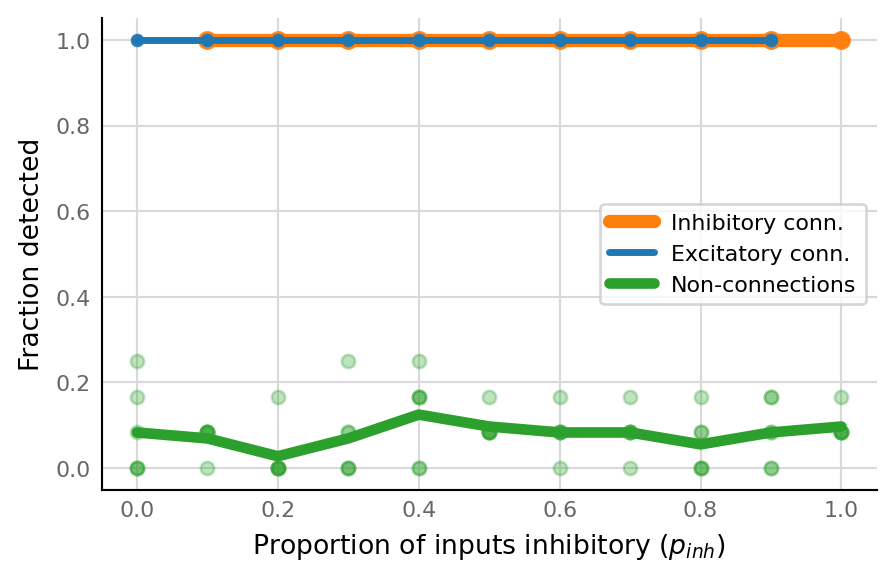

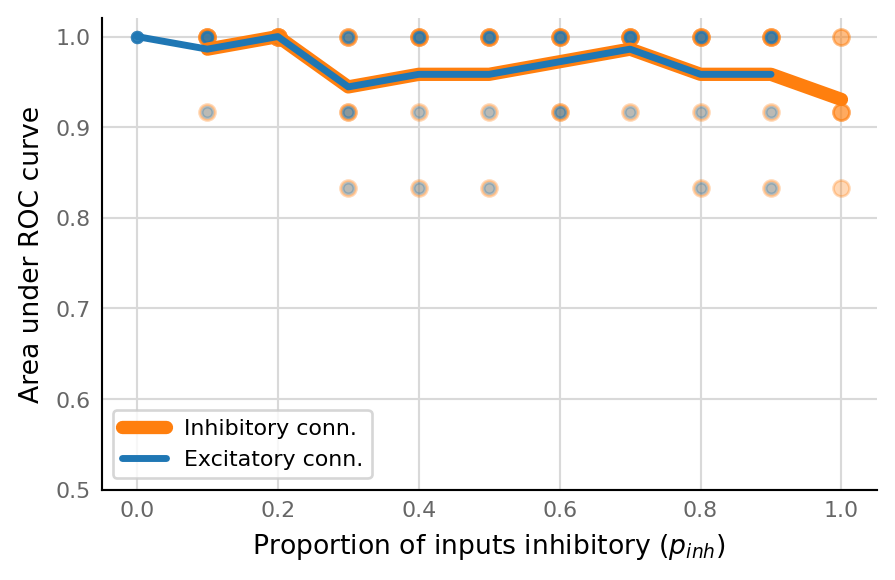

In [40]:
vary_p_inhibited(Params(v_syn_I = -70 * mV));

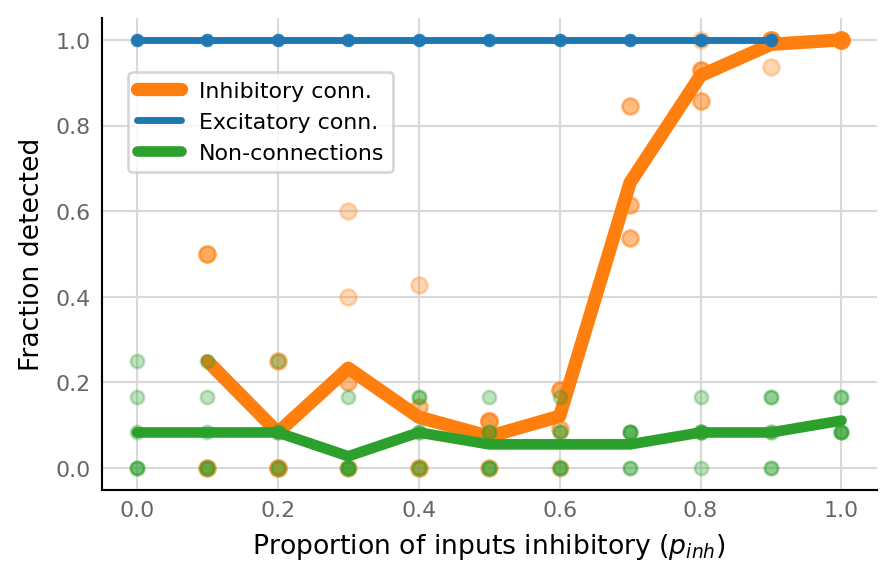

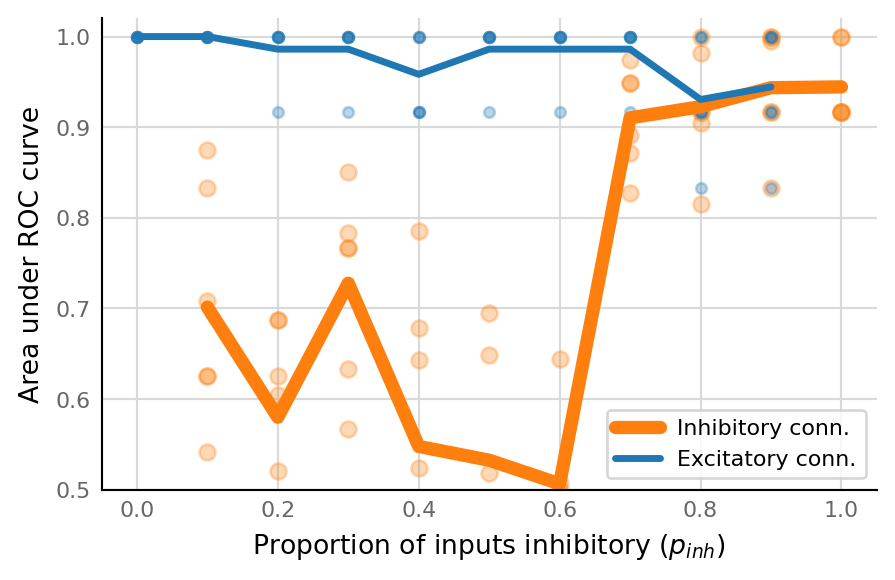

In [43]:
ax1, ax2 = vary_p_inhibited(Params(v_syn_I = -50 * mV))
ax1.legend(loc="center left", bbox_to_anchor=(0.02, 0.78));

Uncached run for two seeds took 16'30".

individual sims getting gradually slower.. from 20 s at start (v -70 p 0 seed 1) to 52 at end (v -50 p 1 seed 2).
Maybe memory drag? python process is at 2GB now.

cache loading is deliciously fast though :)

## Inspect some regimes

In [11]:
from voltage_to_wiring_sim.experiments.N_to_1_IE import Params, simulate_and_test_connections, indices_where

In [12]:
sim_and_test = v.cache_to_disk(simulate_and_test_connections);

16 2
2 16
16 2
2 16


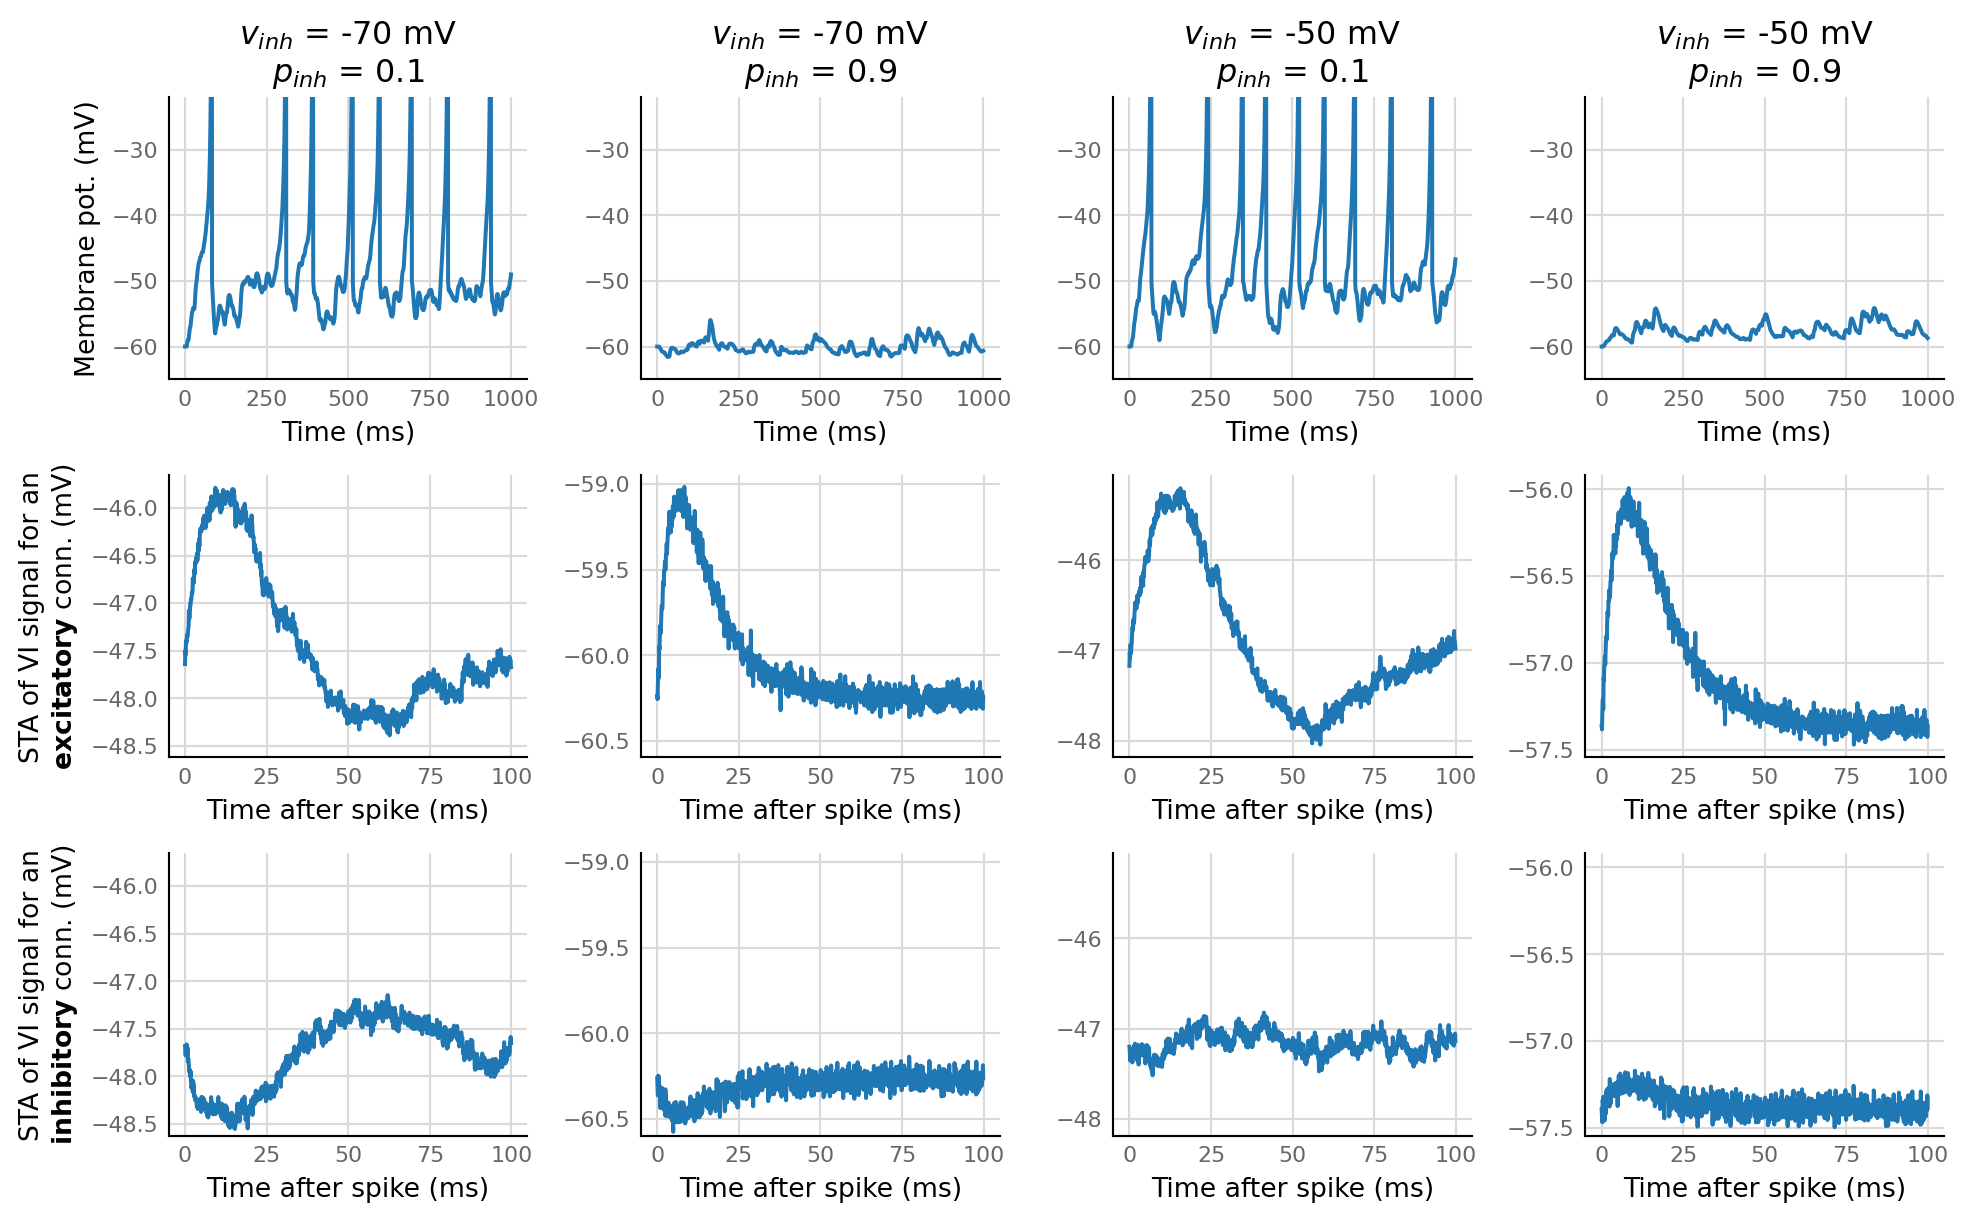

In [148]:
fig, axes = plt.subplots(nrows=3, ncols=4, **v.figsize(width=1000))

for i, (v_syn_I, p_inh) in enumerate(product((-70 * mV, -50 * mV), (0.1, 0.9))):
    
    d, td, ts = sim_and_test(Params(v_syn_I=v_syn_I, p_inhibitory=p_inh))
    
    print(d.num_exc_conn, d.num_inh_conn)
    
    ax = v.plot_signal(d.izh_output.V_m.slice(t_start=0, duration=1*second) / mV, time_units=ms, ax=axes[0, i])
    ax.set_ylim(-65, -22);
    ax.set_xlabel("Time (ms)")
    ax.set_title("$v_{inh}$ = " + f"{v_syn_I / mV:.0f} mV" + "\n" + 
                 "$p_{inh}$ = " + f"{p_inh:.1f}")
    
    
    ax_e = v.plot_STA(td[indices_where(d.is_excitatory & d.is_connected)[0]].original_STA, ax=axes[1, i])
    ax_i = v.plot_STA(td[indices_where(d.is_inhibitory & d.is_connected)[0]].original_STA, ax=axes[2, i])
    
    ylims = (min(ax_i.get_ylim()[0], ax_e.get_ylim()[0]),
             max(ax_i.get_ylim()[1], ax_e.get_ylim()[1]))
    ax_e.set_ylim(ylims)
    ax_i.set_ylim(ylims)
    
    if i == 0:
        ax.set_ylabel("Membrane pot. (mV)");
        ax_e.set_ylabel("STA of VI signal for an" + '\n' + r"$\bf{excitatory}$ conn. (mV)")
        ax_i.set_ylabel("STA of VI signal for an" + '\n' + r"$\bf{inhibitory}$ conn. (mV)")
    else:
        ax_e.set_ylabel(None)
        ax_i.set_ylabel(None)
        
fig.tight_layout()

In [151]:
d, td, ts = sim_and_test(Params(v_syn_I=-50 * mV, p_inhibitory=0.1));

In [153]:
np.median(d.izh_output.V_m) / mV

-50.468785742174646

________________________________________________________________________________
[Memory] Calling voltage_to_wiring_sim.experiments.N_to_1_IE.simulate_and_test_connections...
simulate_and_test_connections(Params(sim_duration=600, timestep=0.0001, spike_rate=20.0, Δg_syn=8.000000000000001e-10, τ_syn=0.007, neuron_params=IzhikevichParams(C=1e-10, k=7e-07, v_r=-0.06, v_t=-0.04, v_peak=0.035, a=30.0, b=-2e-09, c=-0.05, d=1e-10), imaging_spike_SNR=20, v_syn_E=0.0, v_syn_I=-0.07, num_spike_trains=30, p_inhibitory=0.3, p_connected=0.6, window_duration=0.1, rng_seed=0))
30/30
___________________________________simulate_and_test_connections - 32.2s, 0.5min
13 5
9 9
________________________________________________________________________________
[Memory] Calling voltage_to_wiring_sim.experiments.N_to_1_IE.simulate_and_test_connections...
simulate_and_test_connections(Params(sim_duration=600, timestep=0.0001, spike_rate=20.0, Δg_syn=8.000000000000001e-10, τ_syn=0.007, neuron_params=IzhikevichPara

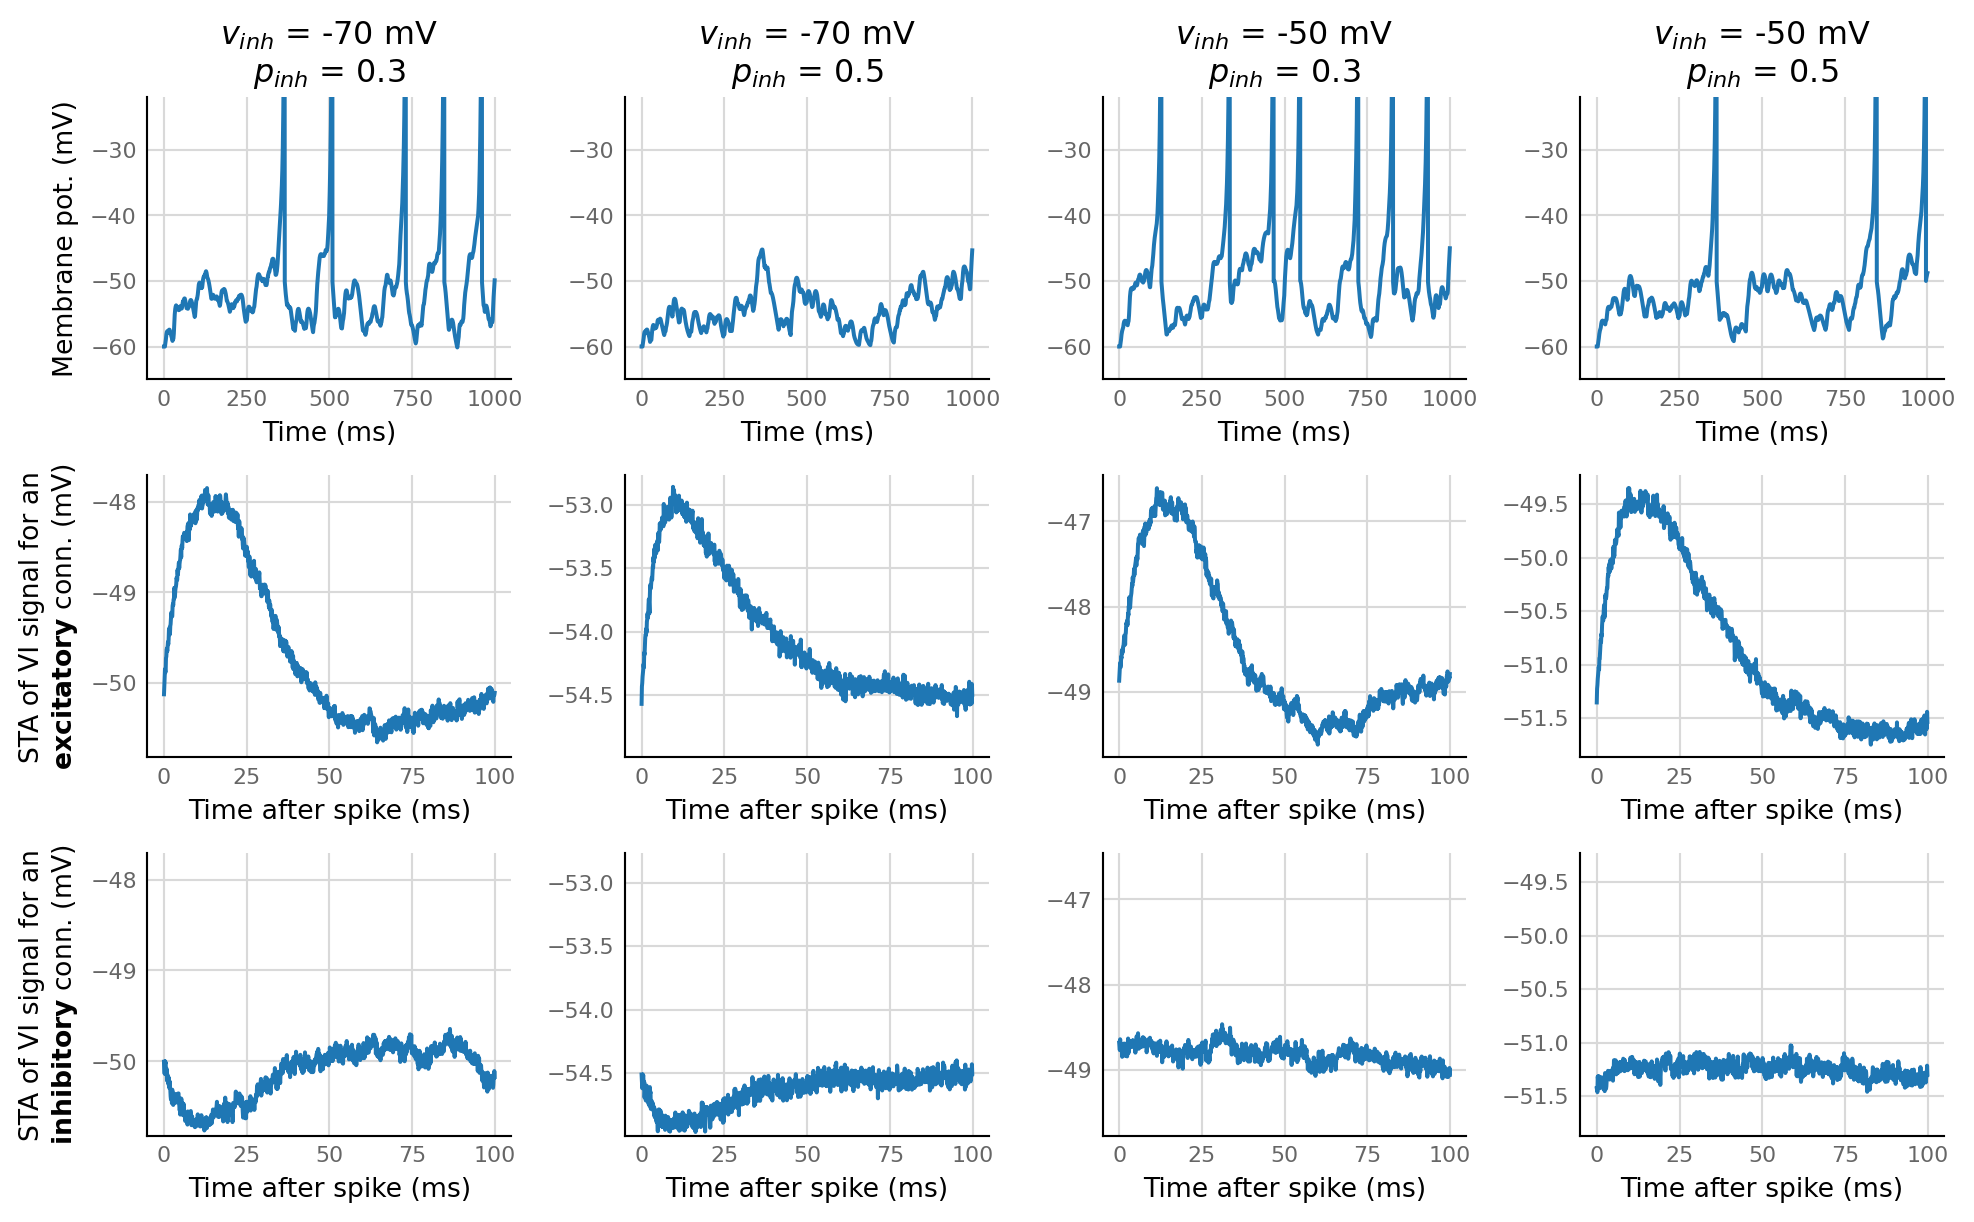

In [150]:
fig, axes = plt.subplots(nrows=3, ncols=4, **v.figsize(width=1000))

for i, (v_syn_I, p_inh) in enumerate(product((-70 * mV, -50 * mV), (0.3, 0.5))):
    
    d, td, ts = sim_and_test(Params(v_syn_I=v_syn_I, p_inhibitory=p_inh))
    
    print(d.num_exc_conn, d.num_inh_conn)
    
    ax = v.plot_signal(d.izh_output.V_m.slice(t_start=0, duration=1*second) / mV, time_units=ms, ax=axes[0, i])
    ax.set_ylim(-65, -22);
    ax.set_xlabel("Time (ms)")
    ax.set_title("$v_{inh}$ = " + f"{v_syn_I / mV:.0f} mV" + "\n" + 
                 "$p_{inh}$ = " + f"{p_inh:.1f}")
    
    
    ax_e = v.plot_STA(td[indices_where(d.is_excitatory & d.is_connected)[0]].original_STA, ax=axes[1, i])
    ax_i = v.plot_STA(td[indices_where(d.is_inhibitory & d.is_connected)[0]].original_STA, ax=axes[2, i])
    
    ylims = (min(ax_i.get_ylim()[0], ax_e.get_ylim()[0]),
             max(ax_i.get_ylim()[1], ax_e.get_ylim()[1]))
    ax_e.set_ylim(ylims)
    ax_i.set_ylim(ylims)
    
    if i == 0:
        ax.set_ylabel("Membrane pot. (mV)");
        ax_e.set_ylabel("STA of VI signal for an" + '\n' + r"$\bf{excitatory}$ conn. (mV)")
        ax_i.set_ylabel("STA of VI signal for an" + '\n' + r"$\bf{inhibitory}$ conn. (mV)")
    else:
        ax_e.set_ylabel(None)
        ax_i.set_ylabel(None)
        
fig.tight_layout()

In [144]:
# v.plot_signal(d.VI_signal.slice(t_start=0, duration=1*second) / mV, time_units=ms);

## Reproducibility

In [9]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `lpxtf3` on `DUIP74576`<br>on **Thu 28 Oct** 2021, at 15:09 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/9de7c00d5c5495e84e5a1c5ed110f9977820ee2a
) (Thu 28 Oct 2021, 14:11).

Uncommited changes to:
```
 M notebooks/2021-09-16__vary_E_vs_I.ipynb
```

Platform:

Windows-10
CPython 3.9.6 (C:\miniforge3\python.exe)
Intel(R) Xeon(R) W-2123 CPU @ 3.60GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.21.1
matplotlib           3.4.2
numba                0.53.1
joblib               1.0.1
seaborn              0.11.1
scipy                1.7.0
preload              2.2
nptyping             1.4.2


Full conda list:

```
# packages in environment at C:\miniforge3:
#
# Name                    Version                   Build  Channel
argon2-cffi               20.1.0           py39hb82d6ee_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
bleach                    3.3.1              pyhd8ed1ab_0    conda-forge
brotlipy                  0.7.0           py39hb82d6ee_1001    conda-forge
ca-certificates           2019.11.28           hecc5488_0    conda-forge/label/cf202003
certifi                   2021.10.8        py39hcbf5309_0    conda-forge
cffi                      1.14.6           py39h0878f49_0    conda-forge
chardet                   4.0.0            py39hcbf5309_1    conda-forge
charset-normalizer        2.0.0              pyhd8ed1ab_0    conda-forge
click                     7.1.2                    pypi_0    pypi
colorama                  0.4.4              pyh9f0ad1d_0    conda-forge
conda                     4.10.3           py39hcbf5309_2    conda-forge
conda-package-handling    1.7.3            py39hb3671d1_0    conda-forge
cryptography              3.4.7            py39hd8d06c1_0    conda-forge
cycler                    0.10.0                   pypi_0    pypi
debugpy                   1.4.1            py39h415ef7b_0    conda-forge
decorator                 5.0.9              pyhd8ed1ab_0    conda-forge
defusedxml                0.7.1              pyhd8ed1ab_0    conda-forge
entrypoints               0.3             pyhd8ed1ab_1003    conda-forge
icu                       68.2                 h0e60522_0    conda-forge
idna                      3.1                pyhd3deb0d_0    conda-forge
importlib-metadata        4.6.1            py39hcbf5309_0    conda-forge
ipykernel                 6.0.3            py39h832f523_0    conda-forge
ipython                   7.25.0           py39h832f523_1    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
jedi                      0.18.0           py39hcbf5309_2    conda-forge
jinja2                    3.0.1              pyhd8ed1ab_0    conda-forge
joblib                    1.0.1                    pypi_0    pypi
jpeg                      9d                   h8ffe710_0    conda-forge
jsonschema                3.2.0              pyhd8ed1ab_3    conda-forge
jupyter_client            6.1.12             pyhd8ed1ab_0    conda-forge
jupyter_contrib_core      0.3.3                      py_2    conda-forge
jupyter_contrib_nbextensions 0.5.1              pyhd8ed1ab_2    conda-forge
jupyter_core              4.7.1            py39hcbf5309_0    conda-forge
jupyter_highlight_selected_word 0.2.0           py39hcbf5309_1002    conda-forge
jupyter_latex_envs        1.4.6           pyhd8ed1ab_1002    conda-forge
jupyter_nbextensions_configurator 0.4.1            py39hcbf5309_2    conda-forge
jupyterlab_pygments       0.1.2              pyh9f0ad1d_0    conda-forge
jupytray                  0.7                      pypi_0    pypi
kiwisolver                1.3.1                    pypi_0    pypi
libclang                  11.1.0          default_h5c34c98_1    conda-forge
libiconv                  1.16                 he774522_0    conda-forge
libpng                    1.6.37               h1d00b33_2    conda-forge
libsodium                 1.0.18               h8d14728_1    conda-forge
libxml2                   2.9.12               hf5bbc77_0    conda-forge
libxslt                   1.1.33               h65864e5_2    conda-forge
libzlib                   1.2.11            h8ffe710_1013    conda-forge
llvmlite                  0.36.0                   pypi_0    pypi
lxml                      4.6.3            py39h4fd7cdf_0    conda-forge
markupsafe                2.0.1            py39hb82d6ee_0    conda-forge
matplotlib                3.4.2                    pypi_0    pypi
matplotlib-inline         0.1.2              pyhd8ed1ab_2    conda-forge
menuinst                  1.4.17           py39hcbf5309_1    conda-forge
miniforge_console_shortcut 2.0                  h57928b3_0    conda-forge
mistune                   0.8.4           py39hb82d6ee_1004    conda-forge
nbclient                  0.5.3              pyhd8ed1ab_0    conda-forge
nbconvert                 6.1.0            py39hcbf5309_0    conda-forge
nbformat                  5.1.3              pyhd8ed1ab_0    conda-forge
nest-asyncio              1.5.1              pyhd8ed1ab_0    conda-forge
notebook                  6.4.0              pyha770c72_0    conda-forge
nptyping                  1.4.2                    pypi_0    pypi
numba                     0.53.1                   pypi_0    pypi
numpy                     1.21.1                   pypi_0    pypi
openssl                   1.1.1l               h8ffe710_0    conda-forge
packaging                 21.0               pyhd8ed1ab_0    conda-forge
pandas                    1.3.1                    pypi_0    pypi
pandoc                    2.14.1               h8ffe710_0    conda-forge
pandocfilters             1.4.2                      py_1    conda-forge
parso                     0.8.2              pyhd8ed1ab_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    8.3.1                    pypi_0    pypi
pip                       21.2.1             pyhd8ed1ab_0    conda-forge
preload                   2.2                      pypi_0    pypi
prometheus_client         0.11.0             pyhd8ed1ab_0    conda-forge
prompt-toolkit            3.0.19             pyha770c72_0    conda-forge
pycosat                   0.6.3           py39hb82d6ee_1006    conda-forge
pycparser                 2.20               pyh9f0ad1d_2    conda-forge
pygments                  2.9.0              pyhd8ed1ab_0    conda-forge
pyopenssl                 20.0.1             pyhd8ed1ab_0    conda-forge
pyparsing                 2.4.7              pyh9f0ad1d_0    conda-forge
pyqt                      5.12.3           py39hcbf5309_7    conda-forge
pyqt-impl                 5.12.3           py39h415ef7b_7    conda-forge
pyqt5-sip                 4.19.18          py39h415ef7b_7    conda-forge
pyqtchart                 5.12             py39h415ef7b_7    conda-forge
pyqtwebengine             5.12.1           py39h415ef7b_7    conda-forge
pyrsistent                0.17.3           py39hb82d6ee_2    conda-forge
pysocks                   1.7.1            py39hcbf5309_3    conda-forge
python                    3.9.6           h7840368_1_cpython    conda-forge
python-dateutil           2.8.2              pyhd8ed1ab_0    conda-forge
python_abi                3.9                      2_cp39    conda-forge
pytz                      2021.1                   pypi_0    pypi
pywin32                   300              py39hb82d6ee_0    conda-forge
pywinpty                  1.1.3            py39h99910a6_0    conda-forge
pyyaml                    6.0              py39hb82d6ee_0    conda-forge
pyzmq                     22.1.0           py39he46f08e_0    conda-forge
qt                        5.12.9               h5909a2a_4    conda-forge
requests                  2.26.0             pyhd8ed1ab_0    conda-forge
ruamel_yaml               0.15.80         py39hb82d6ee_1004    conda-forge
scipy                     1.7.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi
send2trash                1.7.1              pyhd8ed1ab_0    conda-forge
setuptools                49.6.0           py39hcbf5309_3    conda-forge
six                       1.16.0             pyh6c4a22f_0    conda-forge
sqlite                    3.36.0               h8ffe710_0    conda-forge
terminado                 0.10.1           py39hcbf5309_0    conda-forge
testpath                  0.5.0              pyhd8ed1ab_0    conda-forge
tornado                   6.1              py39hb82d6ee_1    conda-forge
tqdm                      4.61.2             pyhd8ed1ab_1    conda-forge
traitlets                 5.0.5                      py_0    conda-forge
typish                    1.9.2                    pypi_0    pypi
tzdata                    2021a                he74cb21_1    conda-forge
ucrt                      10.0.20348.0         h57928b3_0    conda-forge
urllib3                   1.26.6             pyhd8ed1ab_0    conda-forge
vc                        14.2                 hb210afc_5    conda-forge
voltage-to-wiring-sim     0.1                       dev_0    <develop>
vs2015_runtime            14.29.30037          h902a5da_5    conda-forge
wcwidth                   0.2.5              pyh9f0ad1d_2    conda-forge
webencodings              0.5.1                      py_1    conda-forge
wheel                     0.36.2             pyhd3deb0d_0    conda-forge
win_inet_pton             1.1.0            py39hcbf5309_2    conda-forge
wincertstore              0.2             py39hcbf5309_1006    conda-forge
winpty                    0.4.3                         4    conda-forge
winshell                  0.6                      pypi_0    pypi
yaml                      0.2.5                he774522_0    conda-forge
zeromq                    4.3.4                h0e60522_0    conda-forge
zipp                      3.5.0              pyhd8ed1ab_0    conda-forge
zlib                      1.2.11            h8ffe710_1013    conda-forge
```